# Aviation Accident Data Analysis

# Goals
To determine which aircrafts have the lowest risk for the company to start this business.


## Data
This dataset provides a comprehensive record of aircraft accidents that occurred between the years 1919 and 2023. This dataset captures crucial details of each accident, including the date of the incident, registration number of the aircraft involved, the country where the accident occurred, the specific location, the category of the accident, and the number of fatalities.

Accident Categories:

A = Accident

I = Incident

H = Hijacking

C = Criminal occurrence (sabotage, shoot down) O= other occurrence (ground fire, sabotage)

U = type of occurrence unknown

1 = hull-loss

2 = repairable damage

Fatalities hold both aircraft and ground fatalities
The dataset contains 9 columns and  23967 entries

  * Year: Timeline for trend analysis.
  * Aircraft Type: Identifies fleet-specific safety records.
  * Operator: Links safety outcomes to carriers/companies.
  * country/Location: Context for geographical risk.
  * Accident Category: Nature of incident (e.g., mechanical, weather-related).
  * Fatalities (Total/Aboard/Ground): Severity indicators for accidents.

# Limitations
Some missing or incomplete records (e.g., unknown year or operator) reduce completeness.
Historical focus may not fully capture newer aircraft models or regulatory changes.
Regional reporting standards may vary, leading to inconsistencies.
Does not include external variables like weather, maintenance history, or pilot experience, which also influence safety.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
df = pd.read_csv('./Data/aviation-accident-data-2023-05-16.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


## Methods
Cleaning data through inputing missing values, removing duplicates, aligning datatypes, renaming columns


In [88]:
df.rename(columns={'cat': 'accident_category'}, inplace=True)

In [89]:
df.duplicated().sum()   
df.drop_duplicates(inplace=True)

In [90]:
# to separate aircraft fatalities from the fatalities
df['aircraft_fatalities'] = df['fatalities'].apply(
    lambda x: int(str(x).split('+')[0].strip()) 
    if isinstance(x, str) and '+' in x and str(x).split('+')[0].strip().isdigit()
    else int(x) if str(x).isdigit()
    else np.nan
)

In [91]:
## to separate ground fatalities from the fatalities
df['ground_fatalities'] = df['fatalities'].apply(
    lambda x: int(str(x).split('+')[1].strip()) 
    if isinstance(x, str) and '+' in x and str(x).split('+')[1].strip().isdigit()
    else 0 if str(x).isdigit()
    else np.nan
)

In [92]:
# to get total fatalities
df.rename(columns={'fatalities': 'total_fatalities'}, inplace=True)
df['total_fatalities'] = df['total_fatalities'].apply(
    lambda x: sum(int(part.strip()) for part in str(x).split('+')) 
    if isinstance(x, str) and '+' in x 
    else int(x) if str(x).isdigit() 
    else x
)

In [93]:
#dropping rows with a number of missing columns to mantain accuracy of data
df = df[df.isna().sum(axis=1) <= 3]

In [94]:
df['total_fatalities'].fillna(df['total_fatalities'].median(), inplace=True)
df['aircraft_fatalities'].fillna(df['aircraft_fatalities'].median(), inplace=True)
df['ground_fatalities'].fillna(df['ground_fatalities'].median(), inplace=True)

In [95]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = pd.to_datetime(df['year'], errors='coerce')

In [96]:
df.dropna(subset=['date', 'year'], inplace=True)

In [97]:
df['registration'].fillna('Unknown', inplace= True)
df['location'].fillna('Unknown location', inplace= True)
df['operator'].fillna('Unknown', inplace= True)

In [98]:
df['total_fatalities'] = df['total_fatalities'].astype(int)
df['ground_fatalities'] = df['ground_fatalities'].astype(int)
df['aircraft_fatalities'] = df['aircraft_fatalities'].astype(int)
df['operator'] = df['operator'].astype('category')
df['accident_category'] = df['accident_category'].astype('category')
df['type'] = df['type'].astype('category')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22581 entries, 61 to 23966
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 22581 non-null  datetime64[ns]
 1   type                 22581 non-null  category      
 2   registration         22581 non-null  object        
 3   operator             22581 non-null  category      
 4   total_fatalities     22581 non-null  int32         
 5   location             22581 non-null  object        
 6   country              22581 non-null  object        
 7   accident_category    22581 non-null  category      
 8   year                 22581 non-null  datetime64[ns]
 9   aircraft_fatalities  22581 non-null  int32         
 10  ground_fatalities    22581 non-null  int32         
dtypes: category(3), datetime64[ns](2), int32(3), object(3)
memory usage: 1.8+ MB


In [100]:
columns = ['operator', 'accident_category', 'type']
df[columns] = df[columns].apply(lambda x: x.str.strip())

## Results

In [101]:
df.to_csv('./Data/cleaned_aviation_data.csv', index=False)

### Business Recommendation 1
Buying most occuring aircrafts which have the least fatalities per occurence. The implication being that the most common aircrafts are those in the market and can withstand accidents. Curtiss C-46A, Antonov An-2R, Douglas Dakota III (DC-3) are the most preferable options

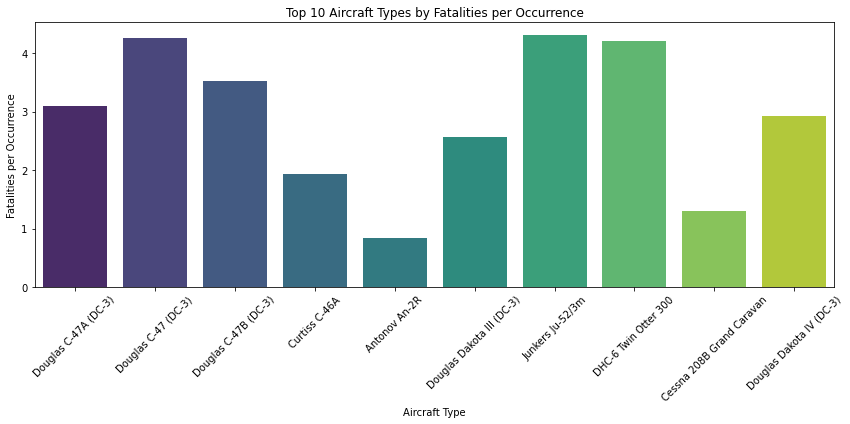

In [ ]:

plane_stats = df.groupby('type').agg(
    occurrences=('type', 'count'),
    total_fatalities=('total_fatalities', 'sum')
).sort_values(by=['occurrences', 'total_fatalities'], ascending=[False, True])

plane_stats['fatalities_per_occurrence'] = plane_stats['total_fatalities'] / plane_stats['occurrences']
plane_stats.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=plane_stats.head(10).index, y=plane_stats.head(10)['fatalities_per_occurrence'], palette='viridis')
plt.title('Top 10 Aircraft Types by Fatalities per Occurrence')
plt.xlabel('Aircraft Type')
plt.ylabel('Fatalities per Occurrence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Business Recommendation 2
Purchasing aircrafts that were involved in accidents but resulted in zero fatalities in the past 20 years.  

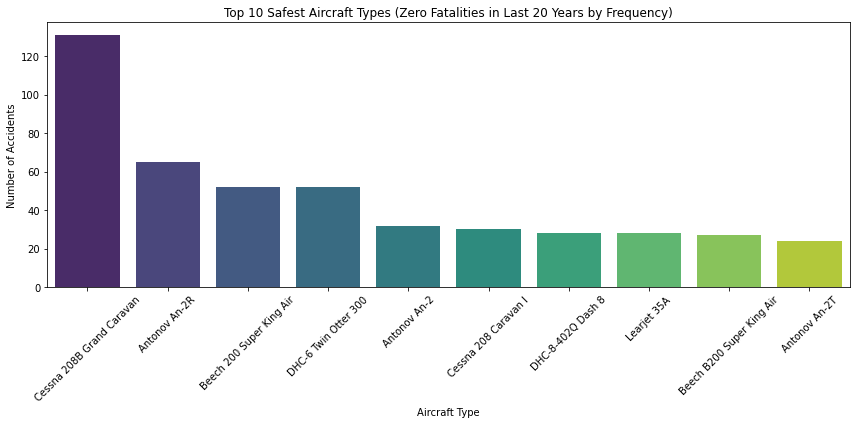

In [ ]:
#aircrafts that were involved in accidents but resulted in zero fatalities in the past 20 years by frequency
safest_types = df['total_fatalities'] == 0
safest_aircrafts = df[safest_types & (df['year'] >= pd.Timestamp.now() - pd.DateOffset(years=20))]
safest_aircrafts = safest_aircrafts['type'].value_counts().head(10)
safest_aircrafts
plt.figure(figsize=(12, 6))
sns.barplot(x=safest_aircrafts.index, y=safest_aircrafts.values, palette='viridis')
plt.title('Top 10 Safest Aircraft Types (Zero Fatalities in Last 20 Years by Frequency)')
plt.xlabel('Aircraft Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Business Recommendation 3
Explore countries with lower fatalities per accident such as Belize, Maldives, Israel, Guyana and Uganda

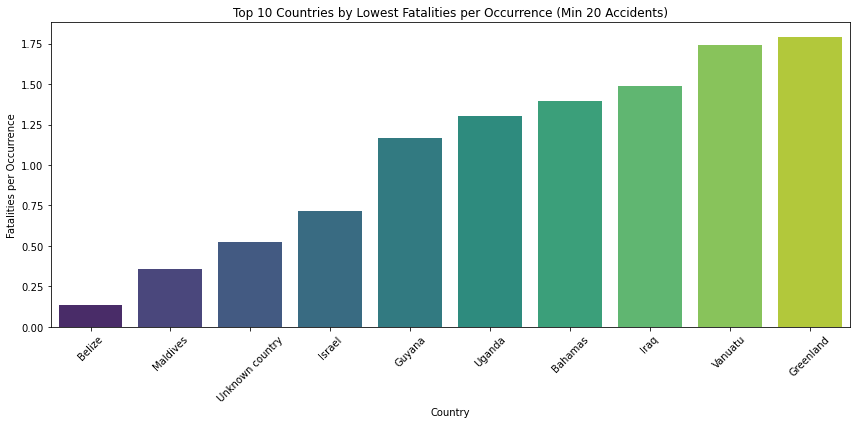

In [107]:
#countries with lower fatalities per accident
country_stats = df.groupby('country').agg(
    occurrences=('country', 'count'),
    total_fatalities=('total_fatalities', 'sum')
).sort_values(by=['occurrences', 'total_fatalities'], ascending=[False, True])  
country_stats['fatalities_per_occurrence'] = country_stats['total_fatalities'] / country_stats['occurrences']
country_stats = country_stats[country_stats['occurrences'] >= 20]
country_stats = country_stats.sort_values(by='fatalities_per_occurrence').head(10)
country_stats
#plotting the countries with lower fatalities per accident
plt.figure(figsize=(12, 6))
sns.barplot(x=country_stats.index, y=country_stats['fatalities_per_occurrence'], palette='viridis')
plt.title('Top 10 Countries by Lowest Fatalities per Occurrence (Min 20 Accidents)')
plt.xlabel('Country')   
plt.ylabel('Fatalities per Occurrence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()